In [3]:
# 📌 Step 1: Imports and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# Load dataset
df = pd.read_excel("Australia_land.xlsx")

# 📌 Step 2: Preprocessing
df = df.rename(columns={df.columns[1]: "Land_used"})
df = df[["Year", "Land_used"]]
df["Land_used"] = pd.to_numeric(df["Land_used"], errors='coerce')
df.dropna(inplace=True)

# Filter based on years
train_df = df[df["Year"] <= 2010].copy()
test_df = df[df["Year"] > 2010].copy()

X_train = train_df[["Year"]]
y_train = train_df["Land_used"]
X_test = test_df[["Year"]]
y_test = test_df["Land_used"]


In [4]:
# Store predictions for comparison
results = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
results['Linear Regression'] = lr.predict(X_test)

# Support Vector Machine
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
results['SVR'] = svr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['Random Forest'] = rf.predict(X_test)

# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)
results['XGBoost'] = xgb.predict(X_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100)
gb.fit(X_train, y_train)
results['Gradient Boosting'] = gb.predict(X_test)


In [5]:
# Scale data for LSTM/GRU
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(df[["Land_used"]])

# Create time series for LSTM/GRU
def create_sequences(data, window=3):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Only up to 2010 for training
train_scaled = scaled_y[df["Year"] <= 2010]
X_lstm, y_lstm = create_sequences(train_scaled, window=3)

# LSTM
model_lstm = Sequential([
    LSTM(64, input_shape=(3, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_lstm, y_lstm, epochs=100, verbose=0)

# Predict 2011–2023 recursively
last_seq = train_scaled[-3:]
lstm_preds = []

for _ in range(len(X_test)):
    pred = model_lstm.predict(last_seq.reshape(1, 3, 1), verbose=0)[0][0]
    lstm_preds.append(pred)
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)

results['LSTM'] = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1)).flatten()

# GRU
model_gru = Sequential([
    GRU(64, input_shape=(3, 1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_lstm, y_lstm, epochs=100, verbose=0)

# Predict recursively
last_seq = train_scaled[-3:]
gru_preds = []

for _ in range(len(X_test)):
    pred = model_gru.predict(last_seq.reshape(1, 3, 1), verbose=0)[0][0]
    gru_preds.append(pred)
    last_seq = np.append(last_seq[1:], [[pred]], axis=0)

results['GRU'] = scaler.inverse_transform(np.array(gru_preds).reshape(-1, 1)).flatten()


c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


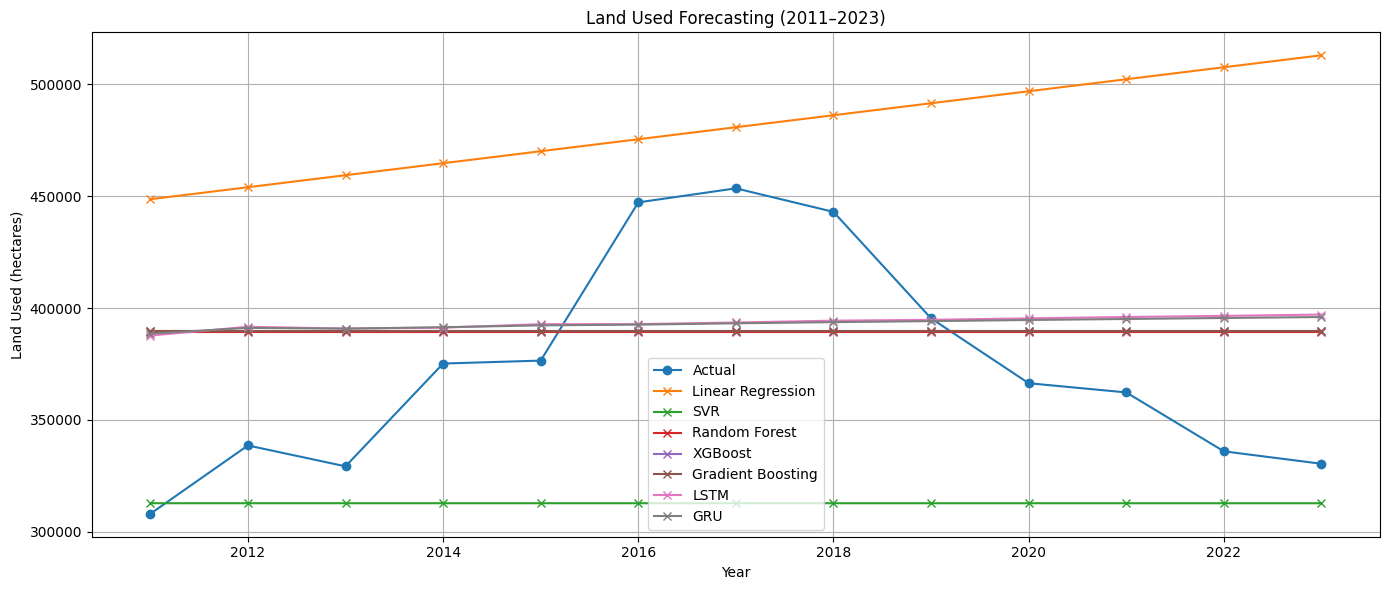

📈 Performance (on 2011–2023):
Linear Regression: MAE = 106762.90, RMSE = 117222.73
SVR: MAE = 61905.35, RMSE = 76800.35
Random Forest: MAE = 43358.24, RMSE = 48952.13
XGBoost: MAE = 43407.03, RMSE = 48992.49
Gradient Boosting: MAE = 43392.85, RMSE = 48980.73
LSTM: MAE = 44603.08, RMSE = 49956.25
GRU: MAE = 44461.34, RMSE = 49839.61


In [6]:
# Plot all models
plt.figure(figsize=(14, 6))
plt.plot(test_df["Year"], y_test.values, label="Actual", marker='o')

for name, preds in results.items():
    plt.plot(test_df["Year"], preds, label=name, marker='x')

plt.legend()
plt.title("Land Used Forecasting (2011–2023)")
plt.xlabel("Year")
plt.ylabel("Land Used (hectares)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print metrics
print("📈 Performance (on 2011–2023):")
for name, preds in results.items():
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")
